Making a strict FSL pipeline due to lab usage and prototyping.

* Do slicetiming and distortion correction here. Do the rest on FEAT GUI, will eventually apply script here.

In [1]:
import sys
import nibabel as nib #3.1.0
import os
import matplotlib # 3.0.3
import matplotlib.pyplot as plt # 3.0.3
import numpy as np #1.18.4
import json #2.0.9
import nipype # 1.4.2
from nipype.interfaces.matlab import MatlabCommand # 1.4.2
import pandas as pd # 0.25.1
import nilearn #  0.6.2
from nilearn import image #  0.6.2
from IPython.display import Image
from nilearn.plotting import plot_glass_brain, plot_anat, \
                                plot_epi, plot_img, view_img  #0.6.2
import scipy # 1.3.1

201013-02:43:40,886 nipype.utils INFO:
	 Running nipype version 1.4.2 (latest: 1.5.1)


In [2]:
base_dir = "/Users/isaacmenchaca/Desktop/SNAPP/fMRI/fMRI_data/sub-03"
output_dir = "/Users/isaacmenchaca/Desktop/SNAPP/fMRI/fMRI_data/sub-03/output"

In [3]:
T1  = nib.load(os.path.join(base_dir, "T1/t1_mprage.nii.gz"))
run1  = nib.load(os.path.join(base_dir, "Trials/Main_task_run1.nii.gz"))
run2  = nib.load(os.path.join(base_dir, "Trials/Main_task_run2.nii.gz"))
run3  = nib.load(os.path.join(base_dir, "Trials/Main_task_run3.nii.gz"))
run4  = nib.load(os.path.join(base_dir, "Trials/Main_task_run4.nii.gz"))
run5  = nib.load(os.path.join(base_dir, "Trials/Main_task_run5.nii.gz"))
run6  = nib.load(os.path.join(base_dir, "Trials/Main_task_run6.nii.gz"))
MT_localizer_run1 = nib.load(os.path.join(base_dir, "Trials/MT_localizer_run1.nii.gz"))
AP = nib.load(os.path.join(base_dir, "fmaps/SE_EPI_task_2mm_AP.nii.gz"))
PA = nib.load(os.path.join(base_dir, "fmaps/SE_EPI_task_2mm_PA.nii.gz"))

In [4]:
print('slices:', run1.shape[2])
print('TR:', run1.header.get_zooms()[-1])
print(run1.header)

slices: 60
TR: 2.0
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b'Peters_SSNAP_P03'
extents         : 16384
session_error   : 0
regular         : b'r'
dim_info        : 185
dim             : [  4 110 106  60 228   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.         2.         2.         1.9999999  2.         0.
  0.         0.       ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 59
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 3229
glmin           : 0
descrip         : b'phase=-y;readout=0.0331;dwell=0.315;TE=32;time=20200206095316.847;'
aux_file        : b';SIEMENS;Main_task_run1_'
qform_code      : scanner
sform_code      : sc

Use Fsleyes or FSLView to find the voxel that is on top of the brain stem and in front of the pons to center BET for skull strip.

After BET. use plot_anat with BET output  (RECOMMEND using fsleyes instead, this is just to document procedure). Adjust fractional intesity threshold to change aggresiveness of BET, find best case with all grey matter and little to no skull. The result is overlaid on the unstripped anatomical scan. You can also make a mask and overlay to inspect as an alternate.

bet /Users/isaacmenchaca/Desktop/SNAPP/fMRI/fMRI_data/sub-03/T1/t1_mprage.nii.gz /Users/isaacmenchaca/Desktop/SNAPP/fMRI/fMRI_data/sub-03/T1/t1_mprage_brain.nii.gz -c 103 140 175 -f 0.25


/opt/anaconda3/lib/python3.7/site-packages/nilearn/image/resampling.py:513: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


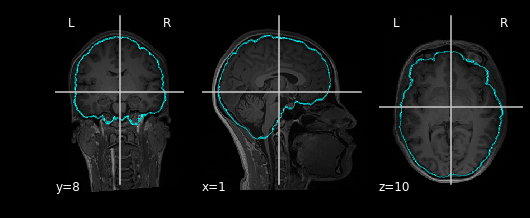

In [5]:
from nipype.interfaces import fsl

btr = fsl.BET()
btr.inputs.in_file = os.path.join(base_dir, "T1/t1_mprage.nii.gz")
btr.inputs.frac = 0.25
btr.inputs.center = [103, 140, 175] # scanner voxels from fsleyes
btr.inputs.output_type = 'NIFTI_GZ'
btr.inputs.out_file = os.path.join(base_dir, "T1/t1_mprage_brain.nii.gz")
btr.run()
print(btr.cmdline)
    
overlay = plot_anat(os.path.join(base_dir, "T1/t1_mprage.nii.gz"),\
                    cut_coords=[1, 8, 10])
overlay.add_contours(os.path.join(base_dir, "T1/t1_mprage_brain.nii.gz"),
                     linewidths=0.5, levels=[.5],
                     colors="cyan")

Slice Timing Correction on all runs

In [6]:
from nipype.interfaces.fsl import SliceTimer

In [7]:
from pathlib import Path

my_file = Path("sliceTimings.txt")

if my_file.is_file():
    print('File already exists.')
else:
    file = base_dir + "/dcmHeaders.mat"
    headerFile = scipy.io.loadmat(file)
    
    # obtain the timings of the 60 slices from the multiBand slice timings
    multiBand_SliceTiming = headerFile['h']['Main_task_run1_2x2x2']\
                                [0, 0]['SliceTiming'][0, 0].squeeze()

    with open('sliceTimings.txt', 'w') as f:
        for sliceTime in multiBand_SliceTiming:
            f.write(str(sliceTime))
            f.write('\n')

In [8]:
st = SliceTimer()
st.inputs.in_file = os.path.join(base_dir, "Trials/Main_task_run1.nii.gz")
st.inputs.custom_timings = 'sliceTimings.txt'
st.inputs.output_type = "NIFTI_GZ"
st.run()
st.cmdline

'slicetimer --in=/Users/isaacmenchaca/Desktop/SNAPP/fMRI/fMRI_data/sub-03/Trials/Main_task_run1.nii.gz --tcustom=sliceTimings.txt --out=/Users/isaacmenchaca/Desktop/SNAPP/fMRI/JupyterAnalysis/Main_task_run1_st.nii.gz'

In [9]:
st = SliceTimer()
st.inputs.in_file = os.path.join(base_dir, "Trials/Main_task_run2.nii.gz")
st.inputs.custom_timings = 'sliceTimings.txt'
st.inputs.output_type = "NIFTI_GZ"
st.run()
st.cmdline

'slicetimer --in=/Users/isaacmenchaca/Desktop/SNAPP/fMRI/fMRI_data/sub-03/Trials/Main_task_run2.nii.gz --tcustom=sliceTimings.txt --out=/Users/isaacmenchaca/Desktop/SNAPP/fMRI/JupyterAnalysis/Main_task_run2_st.nii.gz'

In [10]:
st = SliceTimer()
st.inputs.in_file = os.path.join(base_dir, "Trials/Main_task_run3.nii.gz")
st.inputs.custom_timings = 'sliceTimings.txt'
st.inputs.output_type = "NIFTI_GZ"
st.run()
st.cmdline

'slicetimer --in=/Users/isaacmenchaca/Desktop/SNAPP/fMRI/fMRI_data/sub-03/Trials/Main_task_run3.nii.gz --tcustom=sliceTimings.txt --out=/Users/isaacmenchaca/Desktop/SNAPP/fMRI/JupyterAnalysis/Main_task_run3_st.nii.gz'

In [11]:
st = SliceTimer()
st.inputs.in_file = os.path.join(base_dir, "Trials/Main_task_run4.nii.gz")
st.inputs.custom_timings = 'sliceTimings.txt'
st.inputs.output_type = "NIFTI_GZ"
st.run()
st.cmdline

'slicetimer --in=/Users/isaacmenchaca/Desktop/SNAPP/fMRI/fMRI_data/sub-03/Trials/Main_task_run4.nii.gz --tcustom=sliceTimings.txt --out=/Users/isaacmenchaca/Desktop/SNAPP/fMRI/JupyterAnalysis/Main_task_run4_st.nii.gz'

In [12]:
st = SliceTimer()
st.inputs.in_file = os.path.join(base_dir, "Trials/Main_task_run5.nii.gz")
st.inputs.custom_timings = 'sliceTimings.txt'
st.inputs.output_type = "NIFTI_GZ"
st.run()
st.cmdline

'slicetimer --in=/Users/isaacmenchaca/Desktop/SNAPP/fMRI/fMRI_data/sub-03/Trials/Main_task_run5.nii.gz --tcustom=sliceTimings.txt --out=/Users/isaacmenchaca/Desktop/SNAPP/fMRI/JupyterAnalysis/Main_task_run5_st.nii.gz'

In [13]:
st = SliceTimer()
st.inputs.in_file = os.path.join(base_dir, "Trials/Main_task_run6.nii.gz")
st.inputs.custom_timings = 'sliceTimings.txt'
st.inputs.output_type = "NIFTI_GZ"
st.run()
st.cmdline

'slicetimer --in=/Users/isaacmenchaca/Desktop/SNAPP/fMRI/fMRI_data/sub-03/Trials/Main_task_run6.nii.gz --tcustom=sliceTimings.txt --out=/Users/isaacmenchaca/Desktop/SNAPP/fMRI/JupyterAnalysis/Main_task_run6_st.nii.gz'

In [14]:
st = SliceTimer()
st.inputs.in_file = os.path.join(base_dir, "Trials/MT_localizer_run1.nii.gz")
st.inputs.custom_timings = 'sliceTimings.txt'
st.inputs.output_type = "NIFTI_GZ"
st.run()
st.cmdline

'slicetimer --in=/Users/isaacmenchaca/Desktop/SNAPP/fMRI/fMRI_data/sub-03/Trials/MT_localizer_run1.nii.gz --tcustom=sliceTimings.txt --out=/Users/isaacmenchaca/Desktop/SNAPP/fMRI/JupyterAnalysis/MT_localizer_run1_st.nii.gz'

Combine all runs together

In [15]:
from nipype.interfaces.fsl import Merge

In [16]:
merger = Merge()
merger.inputs.in_files = ['Main_task_run1_st.nii.gz', 'Main_task_run2_st.nii.gz',
                         'Main_task_run3_st.nii.gz', 'Main_task_run4_st.nii.gz',
                         'Main_task_run5_st.nii.gz', 'Main_task_run6_st.nii.gz',
                         'MT_localizer_run1_st.nii.gz']
merger.inputs.dimension = 't'
merger.inputs.output_type = 'NIFTI_GZ'
merger.inputs.merged_file = 'func_sub03_combined.nii.gz'
merger.run()
merger.cmdline # to see the FSL command

'fslmerge -t func_sub03_combined.nii.gz Main_task_run1_st.nii.gz Main_task_run2_st.nii.gz Main_task_run3_st.nii.gz Main_task_run4_st.nii.gz Main_task_run5_st.nii.gz Main_task_run6_st.nii.gz MT_localizer_run1_st.nii.gz'

In [17]:
rm *_st.nii.gz

Susceptibility Distortion Correction

In [18]:
merger = Merge()
merger.inputs.in_files = [os.path.join(base_dir, "fmaps/SE_EPI_task_2mm_AP.nii.gz"),
                          os.path.join(base_dir, "fmaps/SE_EPI_task_2mm_PA.nii.gz")]
merger.inputs.dimension = 't'
merger.inputs.output_type = 'NIFTI_GZ'
merger.run()
merger.cmdline

'fslmerge -t SE_EPI_task_2mm_AP_merged.nii.gz /Users/isaacmenchaca/Desktop/SNAPP/fMRI/fMRI_data/sub-03/fmaps/SE_EPI_task_2mm_AP.nii.gz /Users/isaacmenchaca/Desktop/SNAPP/fMRI/fMRI_data/sub-03/fmaps/SE_EPI_task_2mm_PA.nii.gz'

In [19]:
from nipype.interfaces.fsl import TOPUP

In [20]:
topup = TOPUP()
topup.inputs.in_file = "SE_EPI_task_2mm_AP_merged.nii.gz" # --imain
topup.inputs.encoding_file = "my_acq_param.txt" # --datain
topup.inputs.output_type = "NIFTI_GZ"
topup.run()
topup.cmdline

'topup --config=b02b0.cnf --datain=my_acq_param.txt --imain=SE_EPI_task_2mm_AP_merged.nii.gz --out=SE_EPI_task_2mm_AP_merged_base --iout=SE_EPI_task_2mm_AP_merged_corrected.nii.gz --fout=SE_EPI_task_2mm_AP_merged_field.nii.gz --jacout=jac --logout=SE_EPI_task_2mm_AP_merged_topup.log --rbmout=xfm --dfout=warpfield'

In [21]:
from nipype.interfaces.fsl import ApplyTOPUP

In [22]:
applytopup = ApplyTOPUP()
applytopup.inputs.in_files = "func_sub03_combined.nii.gz"
applytopup.inputs.encoding_file = "my_acq_param.txt"
applytopup.inputs.in_topup_fieldcoef = "SE_EPI_task_2mm_AP_merged_base_fieldcoef.nii.gz"
applytopup.inputs.output_type = "NIFTI_GZ"
applytopup.inputs.in_topup_movpar = "SE_EPI_task_2mm_AP_merged_base_movpar.txt"
applytopup.inputs.method = "jac"
applytopup.run()
applytopup.cmdline

'applytopup --datain=my_acq_param.txt --imain=func_sub03_combined.nii.gz --inindex=1 --topup=SE_EPI_task_2mm_AP_merged_base --method=jac --out=func_sub03_combined_corrected.nii.gz'

In [23]:
mv func_sub03_combined_corrected.nii.gz ../fMRI_data/sub-03/Trials/

combine all timings.

Run FEAT and run motion correction with MCFLIRT to view charts (fix for jupyter later) and register to anatomical image, warp to MNI T152, FWHM smoothing to 4. Z threshold = 2.3, cluster p threshold = 0.5.

Run the GLM on the entire experiment. Contrast conf levels 1, 2, 3, 4 and then high conf -low conf, low-high.

**FUTURE FIXME:** 
* embed motion correction with chart, along with coregistration, warping (univariate), and smoothing (univariate). 
* Make GLM pipeline.
* Run pipelines in parallel with processors for speed.